<a href="https://colab.research.google.com/github/nahatx/30DayMapChal/blob/main/mapChallengeDay1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
import requests
import pandas as pd
from geopy.geocoders import Nominatim
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import time
import warnings

## Fetch and prepare data

In [41]:
# Read an html table into a list of dataframes and select the dataframe containing Prime Ministers and their birth places
raw_minister_dataframe = pd.read_html("https://en.wikipedia.org/wiki/List_of_prime_ministers_of_the_United_Kingdom_by_birthplace")[1]

# filter the dataframe to the desired length of 31, which gives us the ministers since 1900 (27 total)
raw_minister_dataframe = raw_minister_dataframe[31:].copy().reset_index(drop=True)


# Get political party data
raw_party_dataframe = pd.read_html("https://simple.wikipedia.org/wiki/List_of_prime_ministers_of_the_United_Kingdom")[0]

## Clean the data

In [42]:
# Fix names to show first names, not initials
replace_names = {"H. H. Asquith": "Herbert Asquith"}
for key, value in replace_names.items():
    raw_minister_dataframe["Name"] = raw_minister_dataframe["Name"].str.replace(key, value)

# Create a 'Location' collumn that merges the 'Birthplace' and 'Country' columns
raw_minister_dataframe["Location"] = raw_minister_dataframe["Birthplace"] + ", " + raw_minister_dataframe["Country"]


# Fix names to match from both raw_dataframe's
raw_party_dataframe["Name"] = raw_party_dataframe["Name"].str.replace("Marquess of Salisbury", "Robert Gascoyne-Cecil").str.replace(
    "Andrew Bonar Law", "Bonar Law")

## Geocode the location

In [43]:
# Initialize Nominatim geocoder object, do not use default user agent for nominatim.openstreetmap.org API
nom_app = Nominatim(user_agent="map_project1")

latitude = [None] * len(raw_minister_dataframe)
longitude = [None] * len(raw_minister_dataframe)

In [44]:
# Some OpenStreetMap queries will not resolve,
# cache and manually fix each one using www.openstreetmap.org,
# then rerun this block to update them before moving on
needs_location_cleaning = []


# Manually correct and standardize place names for accurate geocoding here
# A fuzzer + a location list can probably be used to automate this on large datasets
replace_birth = {"Chorlton-on-Medlock, Lancashire,": "Chorlton-on-Medlock, Manchester",
                "Lossiemouth, Morayshire": "Lossiemouth, Moray",
                "Putney, Surrey" : "Putney, London",
                "Huddersfield, West Riding of Yorkshire": "Huddersfield, West Yorkshire",
                "Morley, West Riding of Yorkshire": "Morley, West Yorkshire",
                "St Helier, Surrey": "St Helier, London",
                "New Brunswick colony, modern day Canada" : "Canada"}
for key, value in replace_birth.items():
  raw_minister_dataframe["Location"] = raw_minister_dataframe["Location"].str.replace(key, value)


# Update geocoding for locations that have not been geocoded yet
for row in range(len(raw_minister_dataframe)):
  if not (latitude[row] and longitude[row]):
    location_data = nom_app.geocode(raw_minister_dataframe.loc[row]["Location"])
    if location_data:
      latitude[row] = location_data.raw["lat"]
      longitude[row] = location_data.raw["lon"]
    else:
      needs_location_cleaning.append(raw_minister_dataframe.loc[row]["Location"])
    # Must sleep to remain within rate limit (https://operations.osmfoundation.org/policies/nominatim/) AND get list of invalid searches
    time.sleep(1)


# Warn if there are geocoding failures, and output locations that need to be fixed manually
if len(needs_location_cleaning) > 0:
  print(f"Need to fix {len(needs_location_cleaning)} locations.", "Fix them and RERUN BLOCK!",
        "\nLocations:", *needs_location_cleaning, sep="\n")

## Merge datasets and save to a csv file

In [45]:
# Create a new dataframe containing the columns needed from the raw_minister_dataframe
minister_dataframe = pd.DataFrame()
minister_dataframe["Name"] = raw_minister_dataframe["Name"]
minister_dataframe["Latitude"] = latitude
minister_dataframe["Longitude"] = longitude

# Add political party for each Prime Minister
raw_party_dataframe = raw_party_dataframe.drop(columns="Time in office")
minister_dataframe = pd.merge(minister_dataframe, raw_party_dataframe, on="Name", how="inner")
minister_dataframe = minister_dataframe.drop_duplicates().reset_index(drop=True)


# Save the final, clean dataframe to a csv
minister_dataframe.to_csv("uk-prime-ministers-birthplaces.csv")

## Prepare geospacial data for mapping

In [50]:
map_df = pd.read_csv("uk-prime-ministers-birthplaces.csv")

#load world map
map_set = "/geojson/ne_10m_admin_0_countries.geojson"
world_map = gpd.GeoDataFrame.from_file(f"https://raw.githubusercontent.com/nvkelso/natural-earth-vector/master{map_set}")
uk_regions_map = gpd.GeoDataFrame.from_file("https://public.opendatasoft.com/api/explore/v2.1/catalog/datasets/georef-united-kingdom-region/exports/geojson?lang=en&timezone=America%2FChicago")

# Convert the prime minister dataframe to a geodataframe, encoding location data into a geometry
crs = 'EPSG:4326'
geometry = [Point(xy) for xy in zip(map_df['Longitude'].astype(float), map_df['Latitude'].astype(float))]
geo_df = gpd.GeoDataFrame(map_df, crs = crs, geometry = geometry)

## Plot and annotate maps

Text(85, 25, 'Bonar Law\nRexton, Canada')

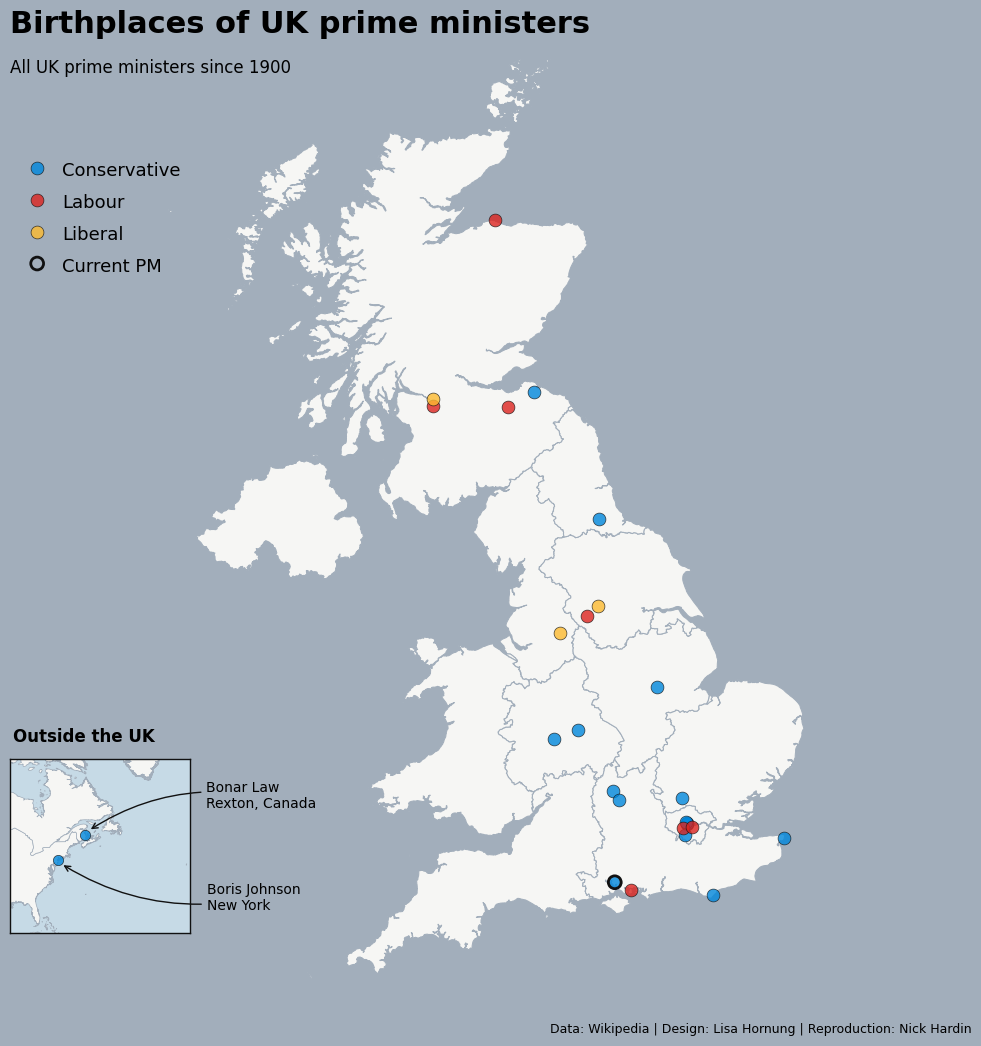

In [56]:
# Create a figure and axis to plot and draw our map
fig, ax = plt.subplots(figsize = (9,10), layout="tight")
# layout="tight" throws warning, but it can be ignored
warnings.filterwarnings('ignore')

# Designate the party colors
pointsPalette = {'Conservative': '#0087DC', 'Liberal': '#FDBB30', 'Labour': '#DC241f'}
# Set the background color of the matplotlib figure to a light blue
fig.set_facecolor("#A2AEBB")

# Reprojects the regions_map GeoDataFrame to the EPSG:4326 coordinate reference system (latitude/longitude)
# Then plots the reprojected regions_map onto ax
uk_regions_map.to_crs(epsg=4326).plot(ax=ax, color='#f6f6f4', edgecolor='#A2AEBB', linewidth=0.75)
# Exclude rows where the Name column contains Boris Johnson or Bonar Law, as they will be plotted seperately
df_uk = geo_df[~geo_df["Name"].isin(["Boris Johnson", "Bonar Law"])]

# Group the dataset by political party,
# then plot each point on the same ax
for ctype, data in df_uk.groupby('Political party'):
  color = pointsPalette[ctype]
  label = ctype
  data.plot(color=color,
            ax=ax,
            label=label,
            markersize=85,
            edgecolor='#111111',
            linewidth=0.5,
            alpha=0.8)

# Make the current prime minister more prominent by using a black circle
current = geo_df[geo_df["Name"].isin(["Rishi Sunak"])]
current.plot( ax=ax, color='None', edgecolor='#111111', linewidth=2, markersize=85, label="Current PM")

# Remove the axis from the edge
ax.axis('off')
# Zoom in a bit on the map
ax.set_xlim(-9, 2)
ax.set_ylim(49.5, 59.5)

# Add a new set of axes to the figure
ax1 = fig.add_axes([0.,0.1,0.2,0.2], anchor='SW', zorder=1)
# Reprojects the world_map to the EPSG:4326, then plots it to the new axes
world_map.to_crs(epsg=4326).plot(ax=ax1, color='#f6f6f4', edgecolor='#A2AEBB', linewidth=0.5)
# Filter for the 2 prime ministers to be plotted outside the UK
df_us = geo_df[geo_df["Name"].isin(["Boris Johnson", "Bonar Law"])]

# Focus ax1 on the specific region where the 2 prime ministers were born in north america
ax1.set_xlim(-90, -30)
ax1.set_ylim(23, 65)
# Remove the axes from the edges
ax1.axes.xaxis.set_visible(False)
ax1.axes.yaxis.set_visible(False)
# The spines of the axes (the borders) are set to black with a linewidth of 1
for pos in ["bottom", "left", "right", "top"]:
  ax1.spines[pos].set(color="#111111", linewidth=1)

# Group the 2 prime ministers by political party, and plot them on ax1 with smaller circles
for ctype, data in df_us.groupby('Political party'):
  color = pointsPalette[ctype]
  label = ctype
  data.plot(color=color,
    ax=ax1,
    label=label,
    markersize=55,
    edgecolor='#111111',
    linewidth=0.5,
    alpha=0.8)

# Set the background of ax1 and add a title
ax1.set_facecolor("#C6DAE6")
ax1.set_title("Outside the UK", fontsize=12, x=0.41, y=1.05, fontweight='bold')

# Add titles
plt.figtext(0,1,'Birthplaces of UK prime ministers', fontsize = 22, weight = 'bold', color='black')
plt.figtext(0,0.96,'All UK prime ministers since 1900', fontsize = 12, weight = 'regular', color='black')
plt.figtext(0.6,0.0,'Data: Wikipedia | Design: Lisa Hornung | Reproduction: Nick Hardin', fontsize = 9, weight = 'regular', color='black')

# Add a legend to the plot
L = ax.legend(ncol=1, frameon=False, loc='upper left',bbox_to_anchor=(-0.2,0.9), labelspacing=1)
plt.setp(L.texts, fontsize=13, va='center',)


# Define the style and color of the arrows used in annotations
kw = dict(arrowstyle="->", color="#111111")
# Annotate Boris Johnson's location
# Extract the long and lat from geo_df
y = float(geo_df[geo_df["Name"]=="Boris Johnson"]["Latitude"].iloc[0])
x = float(geo_df[geo_df["Name"]=="Boris Johnson"]["Longitude"].iloc[0])
# Add Boris Johnson annotation to the plot
ax1.annotate('Boris Johnson\nNew York', xy=(x+1, y-1), xycoords='data', xytext=(105, -25), textcoords='offset points',
              fontsize=10, ha='left', va='center', annotation_clip=False,
              arrowprops=dict(**kw, connectionstyle="arc3,rad=-.2", clip_on=False))
# Annotate Bonar Law's location
# Extract the long and lat from geo_df
y = float(geo_df[geo_df["Name"]=="Bonar Law"]["Latitude"].iloc[0])
x = float(geo_df[geo_df["Name"]=="Bonar Law"]["Longitude"].iloc[0])
# Add Bonar Law annotation to the plot
ax1.annotate('Bonar Law\nRexton, Canada', xy=(x+1, y+1), xycoords='data', xytext=(85, 25), textcoords='offset points',
              fontsize=10, ha='left', va='center', annotation_clip=False,
              arrowprops=dict(**kw, connectionstyle="arc3,rad=.2", clip_on=False))

## Save the final visualization

In [48]:
#save
plt.savefig("birthplaces-uk-prime-ministers.png", dpi=300, bbox_inches="tight", pad_inches=0.2)

<Figure size 640x480 with 0 Axes>